In [1]:
import numpy as np
import matplotlib.pyplot as plt
from comp_optics_utilities import *

#Define units
meter = 1
millimeter = 10** -3 * meter
nanometer = 10** -9 * meter



In [2]:
#README: Introducing alot of new functions, half of them are plotting related
#The most important feature of 2d, is 1: using the 2d Fourier transform, 2: dealing with 2d sample coordinates
#Sample coordinates for 2d need an array (N,N, 2) shape. The last 2 is to store not just an x coordinate,
#but also a y coordinate

In [3]:
#2d sampling

def generate_2d_coordinates(grid_size,grid_dimension):
    
    #Build an array of appropriate size, square of grid points, each point has 2 values, its x coordinate, and y coordinate
    coordinate_array =   grid_dimension / grid_size * np.mgrid[- grid_size // 2: grid_size // 2,- grid_size // 2: grid_size // 2]
        
    #Return the grid, place the non spatial index last, this is generally advised, helps with array manipulations
    # but is not necessary
    return np.swapaxes(coordinate_array,0,2)

In [4]:
#2d Fresnel single Fourier transform

def propagate_fresnel_2d(coordinates, A, _lambda, L):
    #scale the input coordinates correctly, len(coordinates) is the number of samples N
    propagated_coordinates = coordinates * _lambda * L / (np.max(coordinates)-np.min(coordinates))**2 * len(coordinates)
    #apply the FFT (fast DFT) to the field to find the diffraction pattern
    #np.fft.fftshift swaps around the indices of the returned fft from np.fft.fft, since the
    #returned indices before fftshift are not in the normal convenient order physicists like to deal with
    
    #Fresnel quadratic phase factors
    B_fp = np.exp(1.0j * np.pi / _lambda / L * np.sum(propagated_coordinates**2,axis = 2))

    B_f = np.exp(1.0j * np.pi / _lambda / L * np.sum((coordinates)**2, axis = 2))

    propagated_amplitude = B_fp * 1/(1.0j * _lambda * L) * np.exp(1.0j*2*np.pi/_lambda * L) * (np.fft.fftshift((np.fft.fft2(np.fft.fftshift(A * B_f)))))
    
    #return the calculted propagation
    return propagated_coordinates, propagated_amplitude

In [5]:
#return the phase change as a phasor array for a tilted mirror
def small_angle_mirror_phase(coordinates, photon_lambda, angle, axis = "y"):
    if angle > 0.2:
        print("Not a small angle mirror")
    if axis == "y":
        return np.exp(1.0j * 2 * np.pi * 2 * angle * coordinates[:,:,0] / photon_lambda)
    else:
        return np.exp(1.0j * 2 * np.pi * 2 * angle * coordinates[:,:,1] / photon_lambda)
#Returns a unity magnitude complex field encoding the phase due to a mirror tilt.

In [6]:
#Plotting utility for 2d wave amplitudes

def plot_2d_intensity(coordinates, amplitude, name = ""):
    #mirror the plotted amplitude about the x axis, since image arrays are stored opposite of physics convention
    amplitude_plot = np.flip(amplitude, 0) 
    plt.title(name + " 2d Intensity")
    
    #The intensity is maximum normalized, and the coordinate grid is assumed to be square
    #Use the extent =[...] parameter to change the axes to having units of length, rather than index
    plt.imshow(np.square(np.abs(normalize_max(amplitude_plot))), extent = [np.min(coordinates/ millimeter), np.max(coordinates / millimeter)] * 2)
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.colorbar()
    plt.savefig(name + "_intensity.png",dpi = 400)


def plot_2d_phase(coordinates, amplitude, name = ""):
    #mirror the plotted amplitude about the x axis, since image arrays are stored opposite of physics convention
    amplitude_plot = np.flip(amplitude, 0) 
    plt.title(name + " 2d Phase")
    
    #The intensity is maximum normalized, and the coordinate grid is assumed to be square
    #Use the extent =[...] parameter to change the axes to having units of length, rather than index
    
    #Use a cyclic colormap 'twilight'
    #And disable interpolation to remove phase display artifacts
    #np.angle gives phase as -pi to pi, to get 0 to 2pi, just add a constant phase pi
    plt.imshow(np.angle(amplitude_plot) + np.pi, extent = [np.min(coordinates/ millimeter), np.max(coordinates / millimeter)] * 2, cmap = "twilight", vmin = 0.0, vmax = 2 * np.pi, interpolation = "none")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.colorbar()
    plt.savefig(name + "_phase.png",dpi = 400)


In [15]:
def normalize(A):
    return A / np.sqrt(np.sum(np.abs(np.square(A))))


###TASK: 
###Complete the centroid function by correctly multiplying the respective coordinate on the normalized
###intensity distribution before the integral is computed (in this case approximately by sum).
###HINT:
###function super_gaussian_cos has a good example of accessing only the x or only the y coordinate from 2d sample coordinates.

###QUESTION: Which of the above two equations (in the pdf) gives the normalization condition for the transverse intensity? 
###How would the above calculated centroid change if the total intensity was not normalized to unity?


def centroid(coordinates, amplitude):
    
    #Make the sum of the square amplitudes 1, so that calculating the centroid calculation doesnt
    #explicitly require normalization
    amplitude_normalized = normalize(amplitude)
    
    #Coordinates is a 2d array with shape (N,N,2) the last index is for the x or y sample coordinate
    
    #Calculate the expected value for x by summing all sample x coordinates weighted with their normalized intensity
    Ex = ###sum(###Fill in * np.abs(np.square(amplitude_normalized)))

    #Calculate the expected value for y by summing all sample y coordinates weighted with their normalized intensity
    Ey = ###sum(###Fill in * np.abs(np.square(amplitude_normalized)))
    

    #return the centroid
    return Ex,Ey            

In [16]:
#Example amplitude function to test the centroid on
def super_gaussian_cos(coordinates, sigma, center):
    
    #shift the coordinates used so that (0,0) is where CENTER is in the originial coordinates
    coordinates_shifted = coordinates + 0.0
    #Shift the x coordinate 
    coordinates_shifted[:,:,0] -= center[0]
    #Shift the y coordinate
    coordinates_shifted[:,:,1] -= center[1]
    
    
    #Calculate the square radius by summing the x coordinate and y coordinate, squared, for each point
    r_squared = np.sum(coordinates_shifted**2, axis = 2)
    
    return np.exp(-(r_squared**2)/sigma**4) * np.cos(4*np.sqrt(r_squared)/sigma)

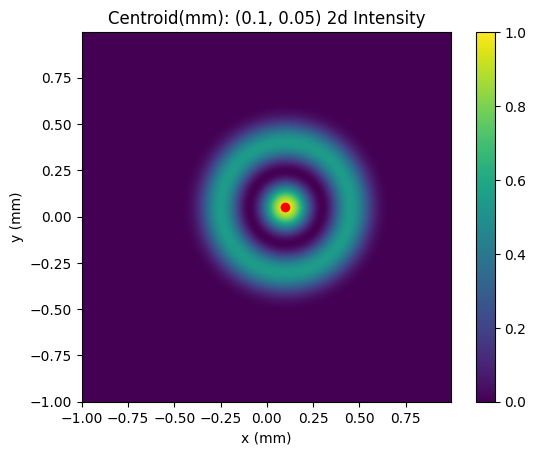

In [19]:
#Coordinates and amplitude pattern to test the centroid
coordinates_centroid_example = generate_2d_coordinates(512,2 * millimeter)

#Notice shift/cent is nonzero
cent = (0.1 * millimeter, 0.05 *  millimeter)
complicated_amplitude = super_gaussian_cos(coordinates_centroid_example, 0.5 * millimeter, cent)

cx,cy = centroid(coordinates_centroid_example, complicated_amplitude)

plot_2d_intensity(coordinates_centroid_example, complicated_amplitude, name = "Centroid(mm): " + str((round(cx/millimeter,4),round(cy/millimeter,4))))

#plot the centroid

plt.plot(cx/millimeter, cy/millimeter, 'ro')

plt.show()

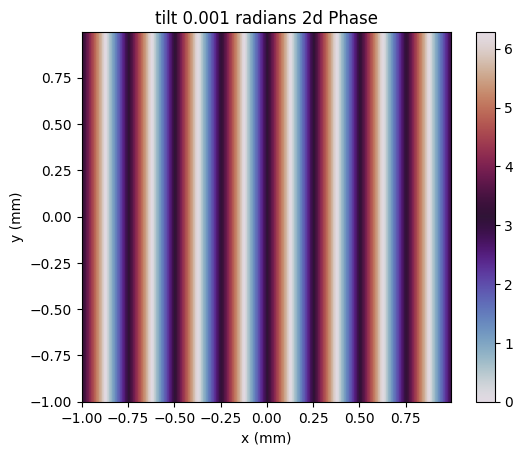

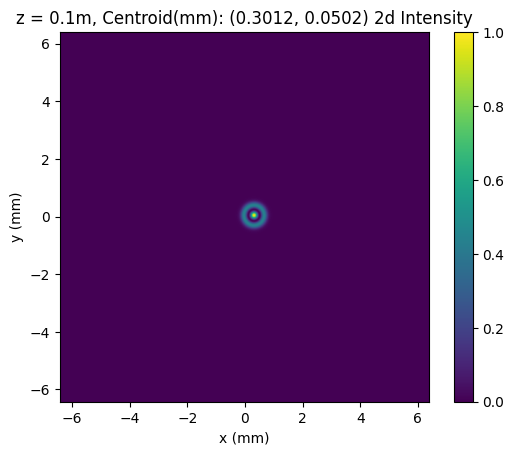

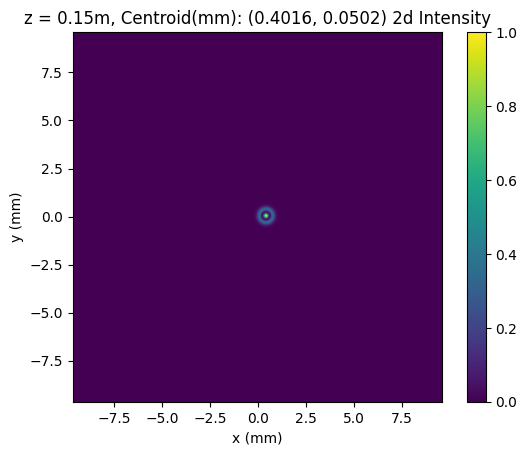

In [14]:
###TASK: generate a mirror tilt phase about the transverse Y axis for a 0.001 rad tilt, to apply on the given beam. 
###HINT: use the provided mirror tilt function
###The tilt will be applied to the above beam used in the centroid example

###QUESTION: Using the centroids of the tilted propagations and initial condition, make a small
###angle calculation of the angle of reflection. Does it match the expected
###angle of reflection?



_lambda = 500 * nanometer

tilt_phase = small_angle_mirror_phase(###Fill in here)
    
tilted_wavefront_amplitude = (###Fill in here) * complicated_amplitude    

plot_2d_phase(coordinates_centroid_example, tilt_phase, "tilt 0.001 radians")
plt.show()

#propagate the example amplitude to two distances with the tilt phase applied 
#(by multiplying the unity magnitude phase you generated)
#Do this for two distances to show the beam has some nonaxial propagation
propagated_coordinates, propagated_amplitude = propagate_fresnel_2d(coordinates_centroid_example, tilted_wavefront_amplitude, _lambda, 0.1 * meter)

cx,cy = centroid(propagated_coordinates, propagated_amplitude)
plot_2d_intensity(propagated_coordinates, propagated_amplitude, name = "z = 0.1m, Centroid(mm): " + str((round(cx/millimeter,4),round(cy/millimeter,4))))

plt.show()

propagated_coordinates, propagated_amplitude = propagate_fresnel_2d(coordinates_centroid_example, tilted_wavefront_amplitude, _lambda, 0.15 * meter)

cx,cy = centroid(propagated_coordinates, propagated_amplitude)
plot_2d_intensity(propagated_coordinates, propagated_amplitude, name = "z = 0.15m, Centroid(mm): " + str((round(cx/millimeter,4),round(cy/millimeter,4))))

plt.show()

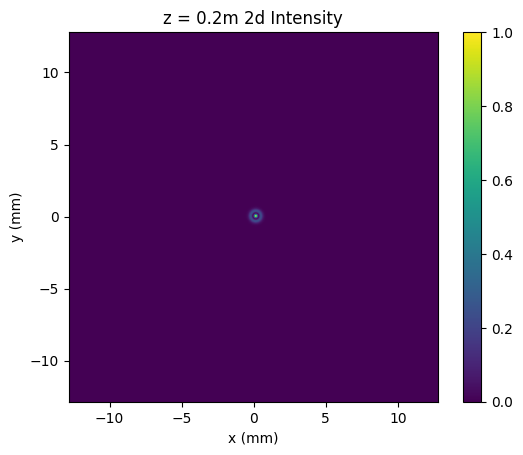

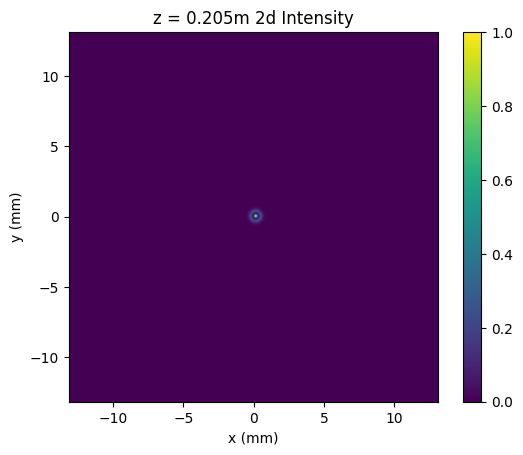

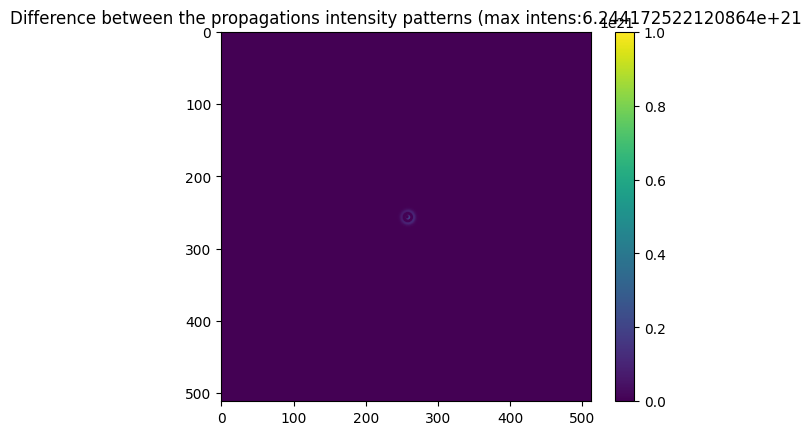

In [12]:
###TASK: 
###Propagate the example amplitude (complicated_amplitude) from z = 0 to z = 0.2m and z = 0.205m.
###Note we can essentially plot with the same coordinates for both z=0.2m and z = 0.205m, since the scale factor
###changes on the order of 2%

propagated_coordinates, propagated_amplitude = propagate_fresnel_2d(###Fill in here)
plot_2d_intensity(propagated_coordinates, propagated_amplitude, "z = 0.2m")
plt.show()

propagated_coordinates, propagated_amplitudep = propagate_fresnel_2d(###Fill in here)
plot_2d_intensity(propagated_coordinates, propagated_amplitudep, "z = 0.205m")
plt.show()

plt.imshow( (np.square(np.abs(propagated_amplitude)) - np.square(np.abs(propagated_amplitudep))) , vmax = 10**21, vmin = 0)
plt.colorbar()
plt.title("Difference between the propagations intensity patterns (max intens:" + str(np.max(np.square(np.abs(propagated_amplitude)))))
plt.savefig("diff_5mm_prop.png", dpi = 400)
plt.show()
